In [55]:
import numpy as np
import librosa
import soundfile as sf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [56]:
import tensorflow as tf

In [57]:
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy

In [58]:
data_dir = "./Music Genre Classification/"            

In [59]:
class FeatureExtractor():
    def __init__(self, datadir ,n_mfccs=13, n_fft=1024, hop_length=512, n_splits=10, hop=2):
        self.n_mfccs = n_mfccs
        self.hop_length = hop_length
        self.MFCCs = []
        self.labels = []
        self.datadir = datadir
        self.hop =  hop
        self.n_fft = n_fft
        self.n_splits = n_splits
    
    def extract_features(self):
        for path, subdirs, files in os.walk(self.datadir):
            for file in files:
                filepath = os.path.join(path, file)
                if file.endswith(".wav"):
                    try:
                        audio, sr = sf.read(filepath)
                        filepathList = filepath.split('/')
                        duration = int(audio.shape[0] / sr)
                        frame = int(duration / self.n_splits)
                        for i in range(0, duration, self.hop):
                            MFCC = librosa.feature.mfcc(y=audio[i*sr: (i+frame)*sr], n_mfcc=self.n_mfccs, n_fft=self.n_fft, hop_length=self.hop_length)
                            genre = filepathList[-2]
                            self.MFCCs.append(MFCC)
                            self.labels.append(genre)        
                    except Exception as e:
                        print("Error encountered while parsing file: ", filepath)
                        print(e)
                        continue

In [13]:
data_extractor = FeatureExtractor(data_dir)
data_extractor.extract_features()

Error encountered while parsing file:  ./Music Genre Classification/Train/jazz/jazz.00054.wav
Error opening './Music Genre Classification/Train/jazz/jazz.00054.wav': Format not recognised.


In [60]:
data_extractor.MFCCs[0].shape

(13, 130)

In [61]:
music_avg_mfccs = {genre: [] for genre in set(data_extractor.labels)}
for i in range(len(data_extractor.labels)):
    avg_mfccs = np.mean(data_extractor.MFCCs[i], axis=1)
    music_avg_mfccs[data_extractor.labels[i]].append(avg_mfccs)

In [62]:
music_avg_mfccs.keys()

dict_keys(['disco', 'rock', 'blues', 'country', 'classical', 'jazz', 'hiphop', 'reggae', 'metal', 'pop'])

In [63]:
X = [music_avg_mfccs[genre] for genre in music_avg_mfccs.keys()]
genres = music_avg_mfccs.keys()

In [64]:
mfccs_dict = {i: [] for i in range(1, data_extractor.n_mfccs+1)}
for i in range(len(genres)):
    test = np.array(X[i])
    for num in range(1, data_extractor.n_mfccs+1):
        mfccs_dict[num].append(test[:, (num-1)])

([<matplotlib.axis.XTick at 0x175da67d0>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

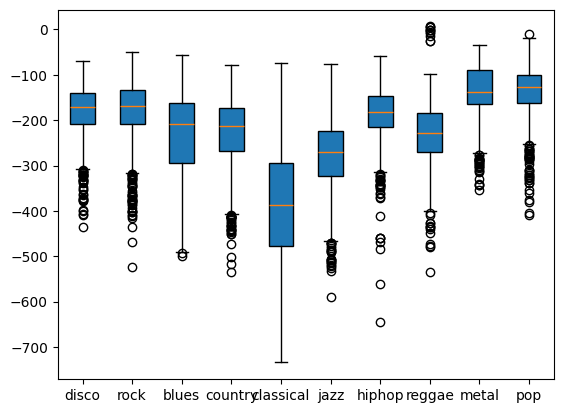

In [65]:
plt.boxplot(mfccs_dict[1], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x1728f42d0>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

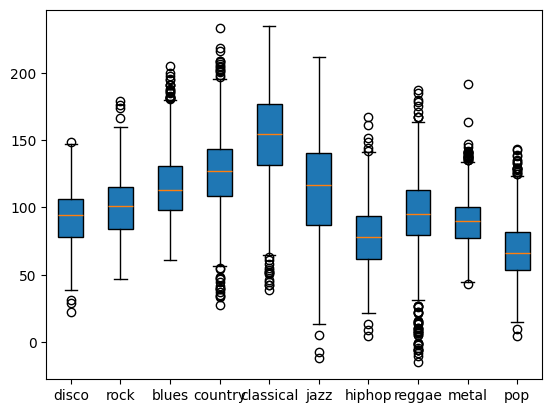

In [66]:
plt.boxplot(mfccs_dict[2], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x17383fd10>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

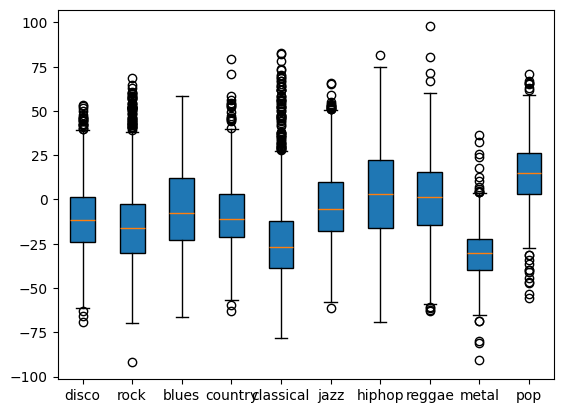

In [67]:
plt.boxplot(mfccs_dict[3], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x1755cca10>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

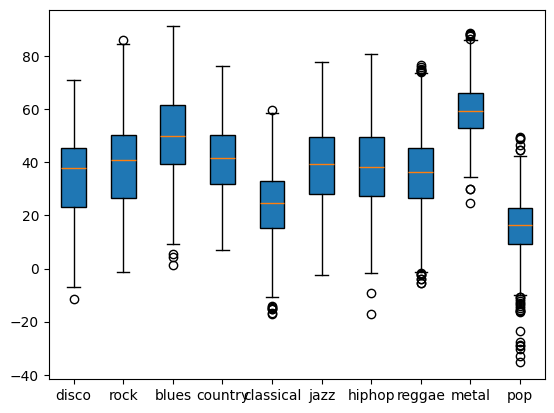

In [68]:
plt.boxplot(mfccs_dict[4], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x175926990>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

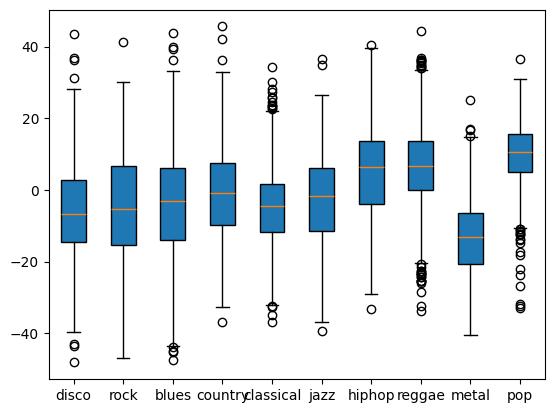

In [69]:
plt.boxplot(mfccs_dict[5], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x1762a97d0>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

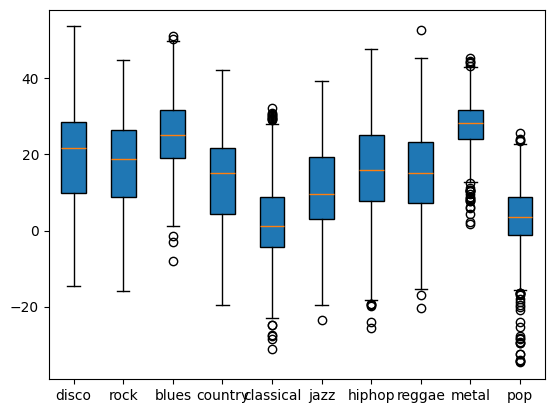

In [70]:
plt.boxplot(mfccs_dict[6], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x17614ac10>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

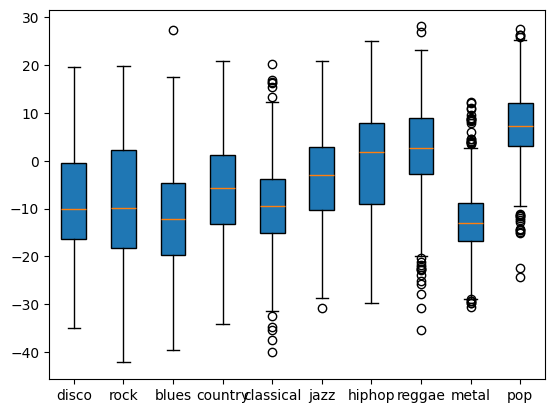

In [71]:
plt.boxplot(mfccs_dict[7], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x177661390>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

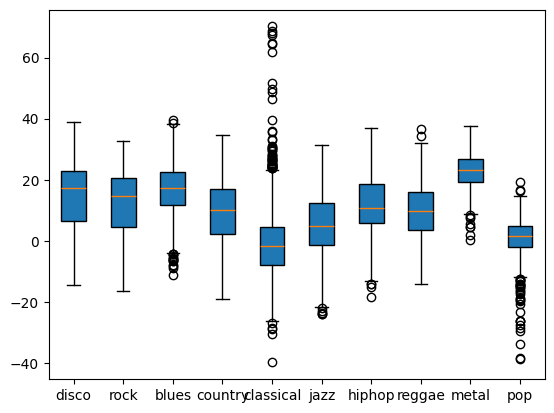

In [72]:
plt.boxplot(mfccs_dict[8], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x177701110>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

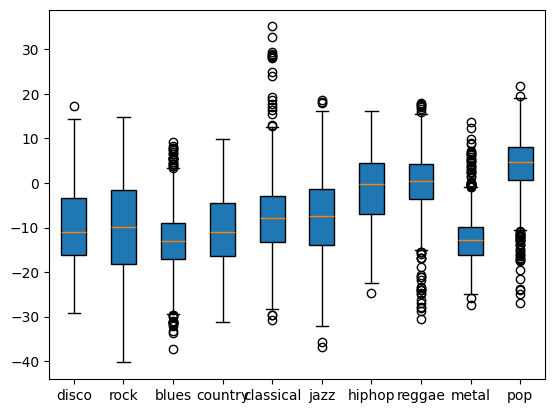

In [73]:
plt.boxplot(mfccs_dict[9], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

([<matplotlib.axis.XTick at 0x177464a10>,
 [Text(1, 0, 'disco'),
  Text(2, 0, 'rock'),
  Text(3, 0, 'blues'),
  Text(4, 0, 'country'),
  Text(5, 0, 'classical'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'hiphop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'metal'),
  Text(10, 0, 'pop')])

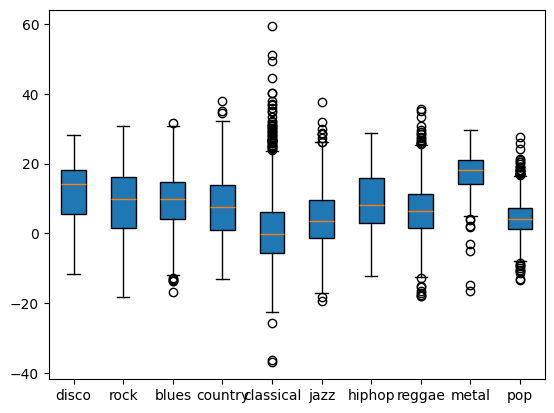

In [74]:
plt.boxplot(mfccs_dict[10], patch_artist=True)
plt.xticks([i for i in range(1, len(genres)+1)], genres)

In [75]:
music_avg_mfccs['rock'][0].shape

(13,)

In [76]:
from tensorflow.keras.callbacks import EarlyStopping

In [147]:
def build_model(input_shape, num_classes):
    
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(num_classes, activation='softmax')
    ])
    
    return model
    

In [148]:
label_encoder = LabelEncoder()
label_encoder.fit(data_extractor.labels)

LabelEncoder()

In [149]:
ANN = build_model((1, 13)
                , 10)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ANN.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [150]:
training_data = []
training_labels = []
for genre in music_avg_mfccs.keys():
    for i in range(len(music_avg_mfccs[genre])):
        training_data.append(music_avg_mfccs[genre][i])
        training_labels.append(label_encoder.transform([genre])[0])
        
training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [151]:
training_labels = to_categorical(training_labels)
training_labels = (training_labels[:, np.newaxis, :])
training_data = (training_data[:, np.newaxis, :])

In [152]:
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels, test_size=0.2)

In [153]:
training_labels.shape
y_train.shape

(9588, 1, 10)

In [154]:
ANN.fit(X_train, y_train, epochs=75, validation_split=0.3,)

Epoch 1/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1417 - loss: 7.7561 - val_accuracy: 0.2656 - val_loss: 3.9211
Epoch 2/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2520 - loss: 3.8813 - val_accuracy: 0.3591 - val_loss: 3.3680
Epoch 3/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3140 - loss: 3.3169 - val_accuracy: 0.3990 - val_loss: 2.8868
Epoch 4/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3630 - loss: 2.8862 - val_accuracy: 0.4355 - val_loss: 2.5726
Epoch 5/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4179 - loss: 2.5478 - val_accuracy: 0.4644 - val_loss: 2.2749
Epoch 6/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4199 - loss: 2.3289 - val_accuracy: 0.4762 - val_loss: 2.1166
Epoch 7/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4630 - loss: 2.1301 - val_accuracy: 0.4950 - val_loss: 1.9827
Epoch 8/75
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4817 - loss: 2.0064 - val_accuracy: 0.

In [155]:
ANN.evaluate(X_test, y_test)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.6478 - loss: 1.1986


[1.2371609210968018, 0.6362119317054749]

In [156]:
ANN.save('model5.keras')

In [38]:
ANN.load_weights('model2.keras')
ANN.evaluate(X_test, y_test)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8245 - loss: 0.7532


[0.7564789056777954, 0.822277843952179]

In [87]:
y_predict_categorical = ANN.predict(X_test)
y_predict = y_predict_categorical.reshape((1, len(X_test), 10))[0]
y_test_reshaped = y_test.reshape((1, len(X_test), 10))[0]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [88]:
y_predict = np.argmax(y_predict, axis=1)
y_test_reshaped = np.argmax(y_test_reshaped, axis=1)

In [89]:
print(classification_report(y_test_reshaped, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       251
           1       0.93      0.93      0.93       236
           2       0.78      0.65      0.71       234
           3       0.68      0.74      0.71       244
           4       0.74      0.73      0.74       235
           5       0.78      0.81      0.79       238
           6       0.86      0.89      0.88       236
           7       0.85      0.90      0.87       230
           8       0.77      0.72      0.74       247
           9       0.73      0.71      0.72       246

    accuracy                           0.79      2397
   macro avg       0.80      0.80      0.79      2397
weighted avg       0.79      0.79      0.79      2397



<Axes: >

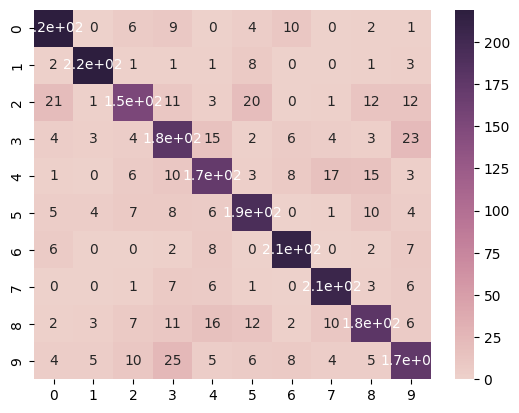

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix = confusion_matrix(y_true=y_test_reshaped, y_pred=y_predict)
sns.heatmap(confusion_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

In [120]:
label_encoder.transform(['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])

array([1, 0, 2, 3, 4, 5, 6, 7, 8, 9])

In [157]:
class ModelPredictior():
    def __init__(self, model_path, input_shape, num_classes, n_mfccs=13, n_fft=1024, hop_length=512):
        self.model_path = model_path
        self.input_shape = input_shape
        self.n_mfccs = n_mfccs
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_classes = num_classes
        
    def build_model(self):
        model = build_model(self.input_shape, self.num_classes)
    
        return model
    
    def train(self):
        pass
    def predict(self, filepath, n_splits=10, hop=2):
        try:
            audio, sr = sf.read(filepath)
            filepathList = filepath.split('/')
            genre = filepathList[-2]
            duration = int(audio.shape[0] / sr)
            predictions = []
            frame = int(duration / n_splits)
            model = self.build_model()
            model.load_weights(self.model_path)
        except Exception as e:
            print(e)
            return
        
        genre_predictions = {}
 
        for i in range(0, duration, hop):
            MFCC = librosa.feature.mfcc(y=audio[i*sr: (i+frame)*sr], n_mfcc=self.n_mfccs, n_fft=self.n_fft, hop_length=self.hop_length)
            MFCC = np.mean(MFCC, axis=1)
            MFCC = MFCC[np.newaxis, :]
            prediction = model.predict(MFCC,  verbose=0)
            prediction = np.argmax(prediction, axis=1)
            predictions.append(prediction[0])
            genre = label_encoder.inverse_transform(prediction)
            genre_predictions[genre[0]] = genre_predictions.get(genre[0], 0) + 1
        
        print(predictions)
        return genre_predictions
        

In [160]:
predictore = ModelPredictior(model_path='model5.keras', input_shape=(13,), num_classes=10)

In [171]:
file_path = "./Music Genre Classification/Train/rock/rock.00023.wav"

predicted_genres = predictore.predict(file_path)
print(predicted_genres)

[6, 9, 9, 9, 9, 9, 9, 2, 9, 9, 9, 9, 5, 2, 2]
{'metal': 1, 'rock': 10, 'country': 3, 'jazz': 1}


In [162]:
label_encoder.transform(['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])

array([1, 0, 2, 3, 4, 5, 6, 7, 8, 9])

In [102]:
import random
test_files = []
n_samples = 20
for path, subdirs, files in os.walk(data_dir):
    print(len(files))
    try:
        random_files = random.sample(files, n_samples)
        for file in random_files:
            filepath = os.path.join(path, file)
            if file.endswith(".wav"):
                test_files.append(filepath)     
    except Exception as e:
        print(e)
        continue
                    

0
Sample larger than population or is negative
0
Sample larger than population or is negative
80
80
80
80
80
80
80
80
80
80


In [ ]:
def max_freq_genre(genres):
    max_freq = 0
    max_genre = ''
    for genre in genres.keys():
        if genres[genre] > max_freq:
            max_freq = genres[genre]
            max_genre = genre
    return max_genre

predictions = []
actual = []
for file in test_files:
    predicted_genres = predictore.predict(file)
    predictions.append(max_freq_genre(predicted_genres))
    actual.append(file.split("/")[-2])
    print("------------------")

In [18]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

       blues       0.95      1.00      0.98        20
   classical       1.00      1.00      1.00        20
     country       1.00      1.00      1.00        20
       disco       0.95      0.95      0.95        20
      hiphop       1.00      0.85      0.92        20
        jazz       1.00      1.00      1.00        20
       metal       0.91      1.00      0.95        20
         pop       0.95      1.00      0.98        20
      reggae       0.95      1.00      0.98        20
        rock       1.00      0.90      0.95        20

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



In [166]:
file_path = "./Data copy/genres_original/rock/rock.00008.wav"

predicted_genres = predictore.predict(file_path)
print(predicted_genres)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
{'country': 15}


In [168]:
import warnings
warnings.filterwarnings('ignore')

In [173]:
for i in range (0, 21):
    if i > 9:
        file_name = f"./Data copy/genres_original/blues/blues.000{i}.wav"
    else : 
        file_name = f"./Data copy/genres_original/blues/blues.0000{i}.wav"
    
    print(file_name)
    predicted_genres = predictore.predict(file_name)
    print(predicted_genres)

./Data copy/genres_original/blues/blues.00000.wav
[2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2]
{'country': 13, 'disco': 2}
./Data copy/genres_original/blues/blues.00001.wav
[8, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3]
{'reggae': 1, 'disco': 10, 'country': 4}
./Data copy/genres_original/blues/blues.00002.wav
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
{'country': 15}
./Data copy/genres_original/blues/blues.00003.wav
[2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
{'country': 14, 'reggae': 1}
./Data copy/genres_original/blues/blues.00004.wav
[1, 9, 5, 9, 9, 1, 1, 9, 5, 1, 1, 1, 1, 5, 5]
{'classical': 7, 'rock': 4, 'jazz': 4}
./Data copy/genres_original/blues/blues.00005.wav
[5, 1, 5, 9, 2, 0, 0, 5, 2, 2, 0, 0, 5, 1, 2]
{'jazz': 4, 'classical': 2, 'rock': 1, 'country': 4, 'blues': 4}
./Data copy/genres_original/blues/blues.00006.wav
[1, 5, 1, 1, 1, 1, 5, 1, 1, 9, 1, 1, 1, 5, 1]
{'classical': 11, 'jazz': 3, 'rock': 1}
./Data copy/genres_original/blues/blues.00007.wav
[5, 2, 2, 2, 2, 5, 2